In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
train = pd.read_csv('Data/train_age_dataset.csv')
len(train)

488877

In [3]:
test = pd.read_csv('Data/test_age_dataset.csv')
len(test)

54320

In [4]:
sample = pd.read_csv('Data/sample_submission.csv')
sample.head()

,prediction
0,1
1,1
2,1
3,1
4,1


## Cleaning

In [5]:
train.isnull().sum()

Unnamed: 0                         0
userId                             0
tier                               0
gender                             0
following_rate                     0
followers_avg_age                  0
following_avg_age                  0
max_repetitive_punc                0
num_of_hashtags_per_action         0
emoji_count_per_action             0
punctuations_per_action            0
number_of_words_per_action         0
avgCompletion                      0
avgTimeSpent                       0
avgDuration                        0
avgComments                        0
creations                          0
content_views                      0
num_of_comments                    0
weekends_trails_watched_per_day    0
weekdays_trails_watched_per_day    0
slot1_trails_watched_per_day       0
slot2_trails_watched_per_day       0
slot3_trails_watched_per_day       0
slot4_trails_watched_per_day       0
avgt2                              0
age_group                          0
d

In [6]:
test.isnull().sum()

Unnamed: 0                         0
userId                             0
tier                               0
gender                             0
following_rate                     0
followers_avg_age                  0
following_avg_age                  0
max_repetitive_punc                0
num_of_hashtags_per_action         0
emoji_count_per_action             0
punctuations_per_action            0
number_of_words_per_action         0
avgCompletion                      0
avgTimeSpent                       0
avgDuration                        0
avgComments                        0
creations                          0
content_views                      0
num_of_comments                    0
weekends_trails_watched_per_day    0
weekdays_trails_watched_per_day    0
slot1_trails_watched_per_day       0
slot2_trails_watched_per_day       0
slot3_trails_watched_per_day       0
slot4_trails_watched_per_day       0
avgt2                              0
dtype: int64

# WHY ARE THERE NO NULL VALUES

In [7]:
train.head()

,Unnamed: 0,userId,tier,gender,following_rate,followers_avg_age,following_avg_age,max_repetitive_punc,num_of_hashtags_per_action,emoji_count_per_action,...,content_views,num_of_comments,weekends_trails_watched_per_day,weekdays_trails_watched_per_day,slot1_trails_watched_per_day,slot2_trails_watched_per_day,slot3_trails_watched_per_day,slot4_trails_watched_per_day,avgt2,age_group
0,265153,48958844,2,1,0.0,0.0,0.0,0,0.0,0.0,...,0.200000,0.0,0.041667,0.025000,0.0,0.000000,0.175000,0.033333,0.0,1
1,405231,51100441,2,2,0.0,0.0,0.0,0,0.0,0.0,...,0.093220,0.0,0.012712,0.018644,0.0,0.084746,0.000000,0.033898,82.5,2
2,57867,6887426,2,1,0.0,0.0,0.0,0,0.0,0.0,...,0.002786,0.0,0.000000,0.000557,0.0,0.002786,0.000000,0.000000,0.0,1
3,272618,50742404,2,1,0.0,0.0,0.0,0,0.0,0.0,...,0.008403,0.0,0.000000,0.001681,0.0,0.000000,0.000000,0.008403,0.0,1
4,251123,45589200,2,2,0.0,0.0,0.0,0,0.0,0.0,...,0.204918,0.0,0.000000,0.049180,0.0,0.008197,0.057377,0.180328,0.0,1


Oh looks like the null values have been filled with zeros

In [11]:
unnamed = train['Unnamed: 0'].value_counts()
unnamed.value_counts()

1    488877
Name: Unnamed: 0, dtype: int64

Dropping this column, it's redundant

Checking the zero null thing

In [14]:
train.groupby(['followers_avg_age']).size()

followers_avg_age
0.000000    406543
1.000000      7734
1.071429         1
1.090909         2
1.100000         4
             ...  
3.600000         8
3.666667        70
3.750000        10
3.800000         2
4.000000      2301
Length: 3495, dtype: int64

In [16]:
train['followers_avg_age'].value_counts()

0.000000    406543
2.000000     15724
1.000000      7734
3.000000      7446
1.500000      4342
             ...  
2.072119         1
1.916049         1
2.186813         1
1.880435         1
1.830846         1
Name: followers_avg_age, Length: 3495, dtype: int64

While zero definitely is looking like the null value replacement, this column has also been centered around some new mean and its range has been shrunk down

In [15]:
train['age_group'].value_counts()

1    308315
4     60803
3     60404
2     59355
Name: age_group, dtype: int64

Judging by the age group categories given here, I am inclined to believe that people will generally follow people in their own age group

Also I can see that some of the numbers in the avg_age given is cleanly being divided by 3 and some by 5, so I'm gonna guess that to shrink the range, the person divided by 30. To center the mean again, let assume that the lowest age possible will be 10 years. So we subtract the whole thing by 20.

In [17]:
train['followers_avg_age_corrected'] = 30*train['followers_avg_age'] - 20

In [18]:
train.groupby(['followers_avg_age_corrected']).size()

followers_avg_age_corrected
-20.000000     406543
 10.000000       7734
 12.142857          1
 12.727273          2
 13.000000          4
                ...  
 88.000000          8
 90.000000         70
 92.500000         10
 94.000000          2
 100.000000      2301
Length: 3495, dtype: int64

In [40]:
test['followers_avg_age_corrected'] = 30*test['followers_avg_age'] - 20

In [60]:
traintest = pd.concat([train, test])
traintest

,Unnamed: 0,userId,tier,gender,following_rate,followers_avg_age,following_avg_age,max_repetitive_punc,num_of_hashtags_per_action,emoji_count_per_action,...,num_of_comments,weekends_trails_watched_per_day,weekdays_trails_watched_per_day,slot1_trails_watched_per_day,slot2_trails_watched_per_day,slot3_trails_watched_per_day,slot4_trails_watched_per_day,avgt2,age_group,followers_avg_age_corrected
0,265153,48958844,2,1,0.000000,0.000000,0.000000,0,0.0,0.0,...,0.000000,0.041667,0.025000,0.000000,0.000000,0.175000,0.033333,0.000,1.0,-20.0
1,405231,51100441,2,2,0.000000,0.000000,0.000000,0,0.0,0.0,...,0.000000,0.012712,0.018644,0.000000,0.084746,0.000000,0.033898,82.500,2.0,-20.0
2,57867,6887426,2,1,0.000000,0.000000,0.000000,0,0.0,0.0,...,0.000000,0.000000,0.000557,0.000000,0.002786,0.000000,0.000000,0.000,1.0,-20.0
3,272618,50742404,2,1,0.000000,0.000000,0.000000,0,0.0,0.0,...,0.000000,0.000000,0.001681,0.000000,0.000000,0.000000,0.008403,0.000,1.0,-20.0
4,251123,45589200,2,2,0.000000,0.000000,0.000000,0,0.0,0.0,...,0.000000,0.000000,0.049180,0.000000,0.008197,0.057377,0.180328,0.000,1.0,-20.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54315,301257,56503645,2,1,0.000000,0.000000,0.000000,0,0.0,0.0,...,0.000000,0.000000,0.108411,0.000000,0.000000,0.140187,0.401869,0.000,NaN,-20.0
54316,39167,39840927,1,1,0.177419,1.666667,2.210526,0,0.0,0.0,...,0.000000,0.072581,0.058065,0.000000,0.040323,0.104839,0.290323,140.325,NaN,30.0
54317,471826,68398375,2,1,0.048387,0.000000,0.000000,3,0.0,0.0,...,0.048387,0.209677,0.158065,0.000000,0.435484,0.048387,0.725806,186.000,NaN,-20.0
54318,13839,51709440,1,2,0.000000,0.000000,0.000000,0,0.0,0.0,...,0.000000,0.088983,0.000000,0.000000,0.000000,0.000000,0.177966,0.000,NaN,-20.0


In [61]:
traintest.groupby(['following_rate']).size()

following_rate
0.000000      345156
0.000686           1
0.000689           1
0.000704           1
0.000772           2
               ...  
426.504000         1
488.362205         1
563.631147         1
685.277778         1
895.304000         1
Length: 16377, dtype: int64

In [62]:
traintest['following_rate_corrected'] = np.round(traintest['following_rate']/0.00000686)

## Model Testing chumma

In [34]:
from sklearn.metrics import f1_score
import lightgbm as lgb

In [63]:
train = traintest[:488877]
test = traintest[488877:]

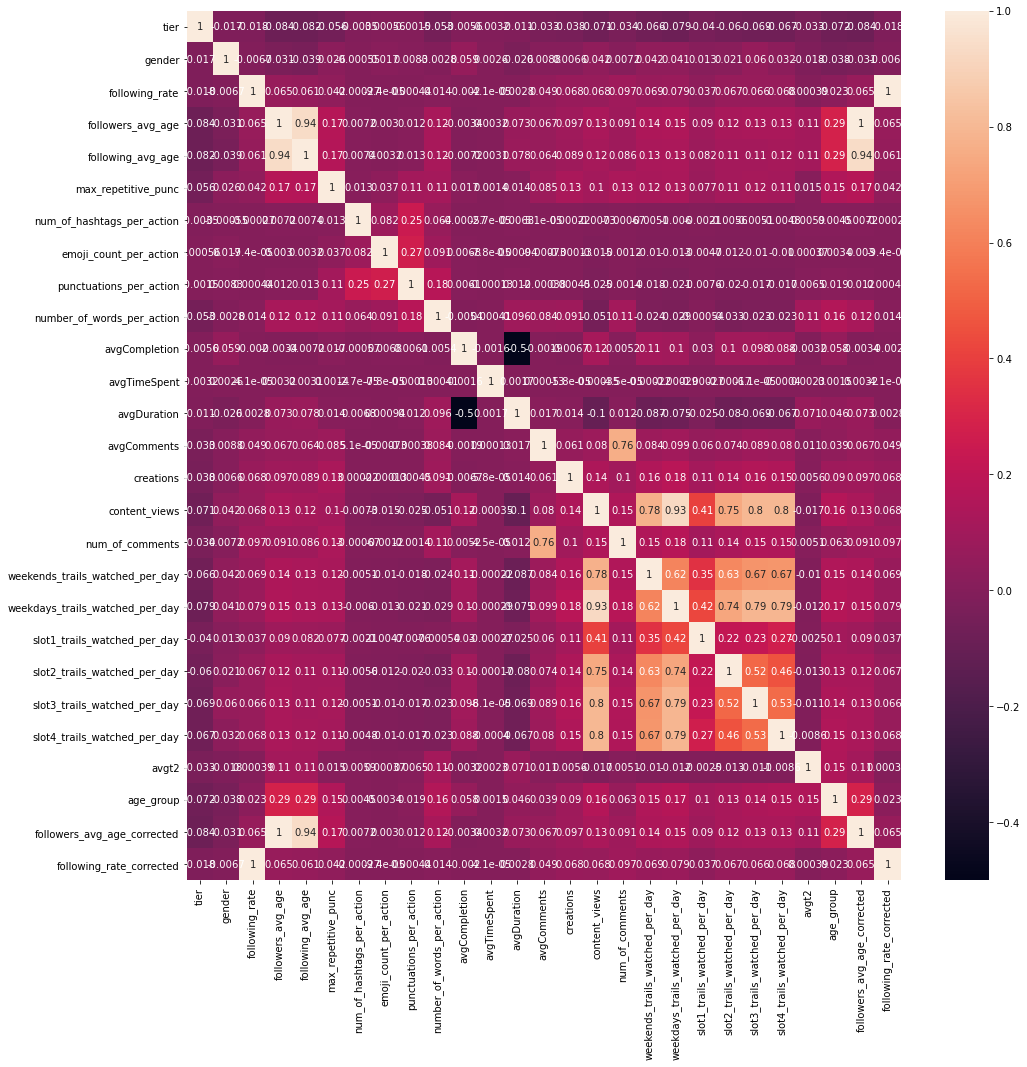

In [70]:
plt.figure(figsize = (16,16))
sns.heatmap(train.drop(['Unnamed: 0', 'userId'], axis = 1).corr(), annot = True)
plt.show()

In [71]:
X = train.drop(['Unnamed: 0', 'userId', 'age_group'], axis = 1)
Y = train['age_group']

In [72]:
from sklearn.model_selection import train_test_split
X_Train, X_CV, Y_Train, Y_CV = train_test_split(X, Y, test_size = 0.15, random_state = 0)

In [73]:
class_weights = {1:308315, 2:59355, 3:60404, 4:60803}
clf = lgb.LGBMClassifier(n_estimators=1000, learning_rate=0.17, n_jobs=8, objective = 'multiclass')
clf.fit(X_Train, Y_Train, early_stopping_rounds = 200, eval_set = [(X_Train, Y_Train), (X_CV, Y_CV)], verbose = True)

[1]	training's multi_logloss: 0.958286	valid_1's multi_logloss: 0.955577
Training until validation scores don't improve for 200 rounds
[2]	training's multi_logloss: 0.882877	valid_1's multi_logloss: 0.88027
[3]	training's multi_logloss: 0.826216	valid_1's multi_logloss: 0.823755
[4]	training's multi_logloss: 0.781995	valid_1's multi_logloss: 0.779647
[5]	training's multi_logloss: 0.747292	valid_1's multi_logloss: 0.745082
[6]	training's multi_logloss: 0.718455	valid_1's multi_logloss: 0.716364
[7]	training's multi_logloss: 0.695356	valid_1's multi_logloss: 0.693325
[8]	training's multi_logloss: 0.676236	valid_1's multi_logloss: 0.674287
[9]	training's multi_logloss: 0.660208	valid_1's multi_logloss: 0.658338
[10]	training's multi_logloss: 0.646912	valid_1's multi_logloss: 0.645084
[11]	training's multi_logloss: 0.635442	valid_1's multi_logloss: 0.633522
[12]	training's multi_logloss: 0.625461	valid_1's multi_logloss: 0.623524
[13]	training's multi_logloss: 0.617449	valid_1's multi_logl

[112]	training's multi_logloss: 0.525034	valid_1's multi_logloss: 0.537701
[113]	training's multi_logloss: 0.524811	valid_1's multi_logloss: 0.537644
[114]	training's multi_logloss: 0.524615	valid_1's multi_logloss: 0.537634
[115]	training's multi_logloss: 0.524324	valid_1's multi_logloss: 0.537465
[116]	training's multi_logloss: 0.523819	valid_1's multi_logloss: 0.537077
[117]	training's multi_logloss: 0.523581	valid_1's multi_logloss: 0.537053
[118]	training's multi_logloss: 0.523376	valid_1's multi_logloss: 0.537052
[119]	training's multi_logloss: 0.523052	valid_1's multi_logloss: 0.536862
[120]	training's multi_logloss: 0.522827	valid_1's multi_logloss: 0.536787
[121]	training's multi_logloss: 0.522592	valid_1's multi_logloss: 0.536726
[122]	training's multi_logloss: 0.522319	valid_1's multi_logloss: 0.536616
[123]	training's multi_logloss: 0.522146	valid_1's multi_logloss: 0.536622
[124]	training's multi_logloss: 0.521967	valid_1's multi_logloss: 0.536629
[125]	training's multi_lo

[222]	training's multi_logloss: 0.502197	valid_1's multi_logloss: 0.532305
[223]	training's multi_logloss: 0.502075	valid_1's multi_logloss: 0.532309
[224]	training's multi_logloss: 0.501918	valid_1's multi_logloss: 0.532311
[225]	training's multi_logloss: 0.501728	valid_1's multi_logloss: 0.532291
[226]	training's multi_logloss: 0.501558	valid_1's multi_logloss: 0.532263
[227]	training's multi_logloss: 0.501385	valid_1's multi_logloss: 0.532276
[228]	training's multi_logloss: 0.501129	valid_1's multi_logloss: 0.532145
[229]	training's multi_logloss: 0.500915	valid_1's multi_logloss: 0.532078
[230]	training's multi_logloss: 0.500731	valid_1's multi_logloss: 0.532039
[231]	training's multi_logloss: 0.500539	valid_1's multi_logloss: 0.532033
[232]	training's multi_logloss: 0.500408	valid_1's multi_logloss: 0.532028
[233]	training's multi_logloss: 0.500246	valid_1's multi_logloss: 0.531994
[234]	training's multi_logloss: 0.499968	valid_1's multi_logloss: 0.531888
[235]	training's multi_lo

[332]	training's multi_logloss: 0.483434	valid_1's multi_logloss: 0.529817
[333]	training's multi_logloss: 0.483283	valid_1's multi_logloss: 0.529801
[334]	training's multi_logloss: 0.48311	valid_1's multi_logloss: 0.529801
[335]	training's multi_logloss: 0.483011	valid_1's multi_logloss: 0.529823
[336]	training's multi_logloss: 0.482857	valid_1's multi_logloss: 0.529826
[337]	training's multi_logloss: 0.482737	valid_1's multi_logloss: 0.529814
[338]	training's multi_logloss: 0.482618	valid_1's multi_logloss: 0.529806
[339]	training's multi_logloss: 0.482479	valid_1's multi_logloss: 0.529799
[340]	training's multi_logloss: 0.48228	valid_1's multi_logloss: 0.52976
[341]	training's multi_logloss: 0.482126	valid_1's multi_logloss: 0.529739
[342]	training's multi_logloss: 0.481984	valid_1's multi_logloss: 0.529728
[343]	training's multi_logloss: 0.481829	valid_1's multi_logloss: 0.529713
[344]	training's multi_logloss: 0.481706	valid_1's multi_logloss: 0.529718
[345]	training's multi_loglo

[442]	training's multi_logloss: 0.467396	valid_1's multi_logloss: 0.528962
[443]	training's multi_logloss: 0.467206	valid_1's multi_logloss: 0.528904
[444]	training's multi_logloss: 0.467084	valid_1's multi_logloss: 0.528895
[445]	training's multi_logloss: 0.466961	valid_1's multi_logloss: 0.528909
[446]	training's multi_logloss: 0.466832	valid_1's multi_logloss: 0.528903
[447]	training's multi_logloss: 0.466713	valid_1's multi_logloss: 0.528916
[448]	training's multi_logloss: 0.466565	valid_1's multi_logloss: 0.528928
[449]	training's multi_logloss: 0.466435	valid_1's multi_logloss: 0.528916
[450]	training's multi_logloss: 0.466319	valid_1's multi_logloss: 0.528918
[451]	training's multi_logloss: 0.46622	valid_1's multi_logloss: 0.528925
[452]	training's multi_logloss: 0.466051	valid_1's multi_logloss: 0.528917
[453]	training's multi_logloss: 0.465904	valid_1's multi_logloss: 0.52891
[454]	training's multi_logloss: 0.465764	valid_1's multi_logloss: 0.528947
[455]	training's multi_logl

[552]	training's multi_logloss: 0.452744	valid_1's multi_logloss: 0.528885
[553]	training's multi_logloss: 0.452608	valid_1's multi_logloss: 0.5289
[554]	training's multi_logloss: 0.45246	valid_1's multi_logloss: 0.528888
[555]	training's multi_logloss: 0.452338	valid_1's multi_logloss: 0.528916
[556]	training's multi_logloss: 0.452196	valid_1's multi_logloss: 0.528897
[557]	training's multi_logloss: 0.45205	valid_1's multi_logloss: 0.528884
[558]	training's multi_logloss: 0.451926	valid_1's multi_logloss: 0.528892
[559]	training's multi_logloss: 0.451792	valid_1's multi_logloss: 0.528856
[560]	training's multi_logloss: 0.451632	valid_1's multi_logloss: 0.528777
[561]	training's multi_logloss: 0.451467	valid_1's multi_logloss: 0.528769
[562]	training's multi_logloss: 0.451371	valid_1's multi_logloss: 0.528775
[563]	training's multi_logloss: 0.451236	valid_1's multi_logloss: 0.528757
[564]	training's multi_logloss: 0.451115	valid_1's multi_logloss: 0.52876
[565]	training's multi_logloss

[663]	training's multi_logloss: 0.438349	valid_1's multi_logloss: 0.528387
[664]	training's multi_logloss: 0.438245	valid_1's multi_logloss: 0.528378
[665]	training's multi_logloss: 0.438116	valid_1's multi_logloss: 0.528375
[666]	training's multi_logloss: 0.43798	valid_1's multi_logloss: 0.528375
[667]	training's multi_logloss: 0.437869	valid_1's multi_logloss: 0.52836
[668]	training's multi_logloss: 0.437754	valid_1's multi_logloss: 0.528372
[669]	training's multi_logloss: 0.437632	valid_1's multi_logloss: 0.528391
[670]	training's multi_logloss: 0.4375	valid_1's multi_logloss: 0.528381
[671]	training's multi_logloss: 0.437369	valid_1's multi_logloss: 0.528362
[672]	training's multi_logloss: 0.4372	valid_1's multi_logloss: 0.528311
[673]	training's multi_logloss: 0.437086	valid_1's multi_logloss: 0.52833
[674]	training's multi_logloss: 0.436962	valid_1's multi_logloss: 0.528327
[675]	training's multi_logloss: 0.43687	valid_1's multi_logloss: 0.528335
[676]	training's multi_logloss: 0

[773]	training's multi_logloss: 0.425411	valid_1's multi_logloss: 0.5286
[774]	training's multi_logloss: 0.425306	valid_1's multi_logloss: 0.528607
[775]	training's multi_logloss: 0.425209	valid_1's multi_logloss: 0.528619
[776]	training's multi_logloss: 0.425096	valid_1's multi_logloss: 0.528619
[777]	training's multi_logloss: 0.424987	valid_1's multi_logloss: 0.528617
[778]	training's multi_logloss: 0.424879	valid_1's multi_logloss: 0.52865
[779]	training's multi_logloss: 0.424767	valid_1's multi_logloss: 0.528659
[780]	training's multi_logloss: 0.424657	valid_1's multi_logloss: 0.528679
[781]	training's multi_logloss: 0.424559	valid_1's multi_logloss: 0.528713
[782]	training's multi_logloss: 0.424454	valid_1's multi_logloss: 0.528729
[783]	training's multi_logloss: 0.424372	valid_1's multi_logloss: 0.528723
[784]	training's multi_logloss: 0.424275	valid_1's multi_logloss: 0.528739
[785]	training's multi_logloss: 0.42417	valid_1's multi_logloss: 0.528744
[786]	training's multi_loglos

LGBMClassifier(learning_rate=0.17, n_estimators=1000, n_jobs=8,
               objective='multiclass')

In [74]:
pred = clf.predict(X_CV)
print(f1_score(Y_CV, pred, average = 'weighted'))

0.7479491533237735


In [59]:
from xgboost import XGBClassifier
xgb = XGBClassifier(n_estimators=1000, class_weights = class_weights,
                    learning_rate=0.17, n_jobs=8, objective = 'multiclass')
xgb.fit(X_Train, Y_Train, early_stopping_rounds = 200, eval_set = [(X_Train, Y_Train), (X_CV, Y_CV)], verbose = True)

[12:49:08] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { class_weights } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-merror:0.29528	validation_1-merror:0.29403
Multiple eval metrics have been passed: 'validation_1-merror' will be used for early stopping.

Will train until validation_1-merror hasn't improved in 200 rounds.
[1]	validation_0-merror:0.29435	validation_1-merror:0.29369
[2]	validation_0-merror:0.29180	validation_1-merror:0.29128
[3]	validation_0-merror:0.28944	validation_1-merror:0.28935
[4]	validation_0-merror:0.28881	validation_1-merror:0.28927
[5]	validation_0-merror:0.28686	validation_1-merror:0.28719
[6]	validation_0-merror:0.28468	validation_1-merror:0.28566
[7]	validation_0-merror:0

KeyboardInterrupt: 

In [ ]:
pred = xgb.predict(X_CV)
print(f1_score(Y_CV, pred, average = 'weighted'))

In [56]:
test_pred = xgb.predict(test.drop(['Unnamed: 0', 'userId'], axis = 1))
test_pred = pd.DataFrame(test_pred, columns = ['prediction'])

In [57]:
test_pred.head()

,prediction
0,1
1,1
2,1
3,2
4,1


In [58]:
test_pred.to_csv('Preds/Submission3.csv', index = False)